In [41]:
import math
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import random
from scipy import integrate, stats
import sympy
import typing

random.seed(1)
sympy.init_printing()


In [2]:
nbm.print_metadata()


context: local
hostname: thinkpad
interpreter: 3.8.10 (default, Nov 26 2021, 20:14:08)  [GCC 9.3.0]
nbcellexec: 2
nbname: mildest_extrema_popsize_confidence_interval
nbpath: /home/mmore500/2022-01-29/hereditary-stratigraph-concept/binder/popsize/mildest_extrema_popsize_confidence_interval.ipynb
revision: null
session: 2be2ef0c-2b0f-47e6-be96-d2360b5d99e6
timestamp: 2022-02-07T22:12:46Z00:00


IPython==7.13.0
keyname==0.4.1
yaml==5.3.1
nbmetalog==0.2.5
numpy==1.19.5
scipy==1.6.0
sympy==1.5.1
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==18.1.1
json==2.0.9
six==1.16.0
ipykernel==5.2.0


# Goal

Calculate a $c\%$ confidence interval for population size $n$ that takes into account $k$ independent observations of fixed gene magnitude.


# Strategy

Extend the approach from notebook [single_observation_popsize_confidence_interval.ipynb](single_observation_popsize_confidence_interval.ipynb), where the confidence interval excluded all $n$ for which an outcome as-or-more-extreme than observed was had probability less than $1-c\%$.

This requires an expression for probability density of the observed outcome given population size $n$.
Deriving a probability density function for the sum of $k$ replicate observations is difficult.
However, through the magic of order statistics, an expression for the probability density of the least-extreme of the $k$ replicate observations is feasible.
This will allow us to compute a confidence interval for $n$ in terms of the least-extreme observed fixed gene magnitude $\hat{x}_1$.

At face value, estimating population size $n$ from fixed gene magnitude seems highly susceptible to skew by rare events.
A single extremely-high magnitude gene anywhere within a population will fix and distort the estimate of $n$.
Therefore there may be some benefit to estimating $n$ by means of the least extreme of $k$ replicate observations with respect to resilience against skew from rare events.
However, this approach also seems likely to suffer from "discarding" information from the other more extreme $k-1$ observations.


# Probability Density Function of Least-Extreme Fixed Gene Magnitude

According to [(Miller, 2017)](#miller2017probability),


> For a random sample of size $n$ having values $x$ and continuous density $f(x)$, the probability density of the $r$th order statistic $Y_r$ is given by
>
> $
g_r(y_r) 
=
\frac{n!}{(r-1)!}{(n-r)!}
\Big(\int_{-\infty}^{y_r} f(x) \, \mathrm{d}x \Big)^{r-1}
f(y_r)
\Big(\int_{y_r}^{\infty} f(x) \, \mathrm{d}x \Big)^{n-r}
$
>
> and for $Y_1$ (smallest value),
>
> $
f_1(y) 
=
n
f(y)
\Big(\int_{y}^{\infty} f(x) \, \mathrm{d}x \Big)^{n-1}.
$

So, with $k$ observations the probability density function of the least-extreme fixed gene is,

$\begin{align*}
p_1(x) 
&= k f(x) \Big(\int_{x}^{\infty} f(u) \, \mathrm{d}u \Big)^{k-1}\\
&= k nx^{n-1} \Big(\int_{x}^{\infty} nu^{n-1} \, \mathrm{d}u \Big)^{k-1}\\
&= k nx^{n-1} \Big(\int_{x}^{1} nu^{n-1} \, \mathrm{d}u \Big)^{k-1}\\
&= k nx^{n-1} \Big(u^{n} |_x^1 \Big)^{k-1}\\
&= k nx^{n-1} \Big(1^{n} - x^n \Big)^{k-1}\\
&= k nx^{n-1} \Big(1 - x^n \Big)^{k-1}.
\end{align*}$

# Upper Bound

As the upper bound for our confidence interval estimating $n$, we will find the $n_\mathrm{ub}$ where integrating the lower tail of probability density beyond $\hat{x}_1$ contains only $(1-c)/2\%$ probability mass.

We must solve

$\begin{align*}
(1-c)/2 
&= \int_0^{\hat{x}_1}  k n_\mathrm{ub} x^{n_\mathrm{ub}-1} \Big(1 - x^n_\mathrm{ub} \Big)^{k-1} \, \mathrm{d}x
\end{align*}$

for $n_\mathrm{ub}$.

Sympy fails to solve for arbitrary $k$, so we will solve for $k=1,2,3,\dots$ and then extrapolate.

In [8]:
# specify variables with assumptions for domain
def solve_for_ub(*, k: int):

    x = sympy.Symbol('x', nonnegative=True, real=True,)
    n = sympy.Symbol('n_\mathrm{lb}', positive=True, real=True,)

    probability_density = k * n * x ** (n - 1) * (1 - x**n)**(k-1)

    x1 = sympy.Symbol('\hat{x}_1', nonnegative=True, real=True,)

    integrated = sympy.integrate(
        probability_density,
        (x, 0, x1,),
    ).simplify()

    c = sympy.Symbol('c', positive=True, real=True,)
        
    equation = sympy.Eq( integrated, (1-c)/2 ).simplify()

    solutions = sympy.solve(equation, n)

    return solutions[0].simplify()


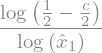

In [9]:
solve_for_ub(k=1,)

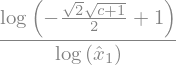

In [10]:
solve_for_ub(k=2,)

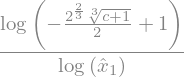

In [11]:
solve_for_ub(k=3,)

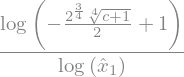

In [12]:
solve_for_ub(k=4,)

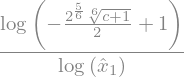

In [13]:
# sympy can't solve this case
#solve_for_ub(k=5,)

solve_for_ub(k=6,)

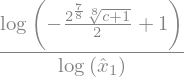

In [14]:
# sympy can't solve this case
# solve_for_ub(k=7,)

solve_for_ub(k=8,)

Solution appears to be of the form

$\begin{align*}
n_\mathrm{ub}
&=\frac{
    \log \Big( - \frac{2^\frac{k-1}{k} (c+1)^{1/k}}{2} + 1 \Big)
}{\log( \hat{x}_1 )}\\
&=\frac{
    \log \Big( - 2^\frac{-1}{k} (c+1)^{1/k} + 1 \Big)
}{\log( \hat{x}_1 )}\\
&=\frac{
    \log \Big( - \frac{c+1}{2}^{1/k} + 1 \Big)
}{\log( \hat{x}_1 )}\\
&=\frac{
    \log \Big( 1 - \frac{1+c}{2}^{1/k} \Big)
}{\log( \hat{x}_1 )}.
\end{align*}$

# Validating Upper Bound Extrapolation

To validate the upper bound, we will run numeric integration with specific values of $c$ and $\hat{x}_1$ to test solutions for more values of $k$.


In [15]:
def expected_ub(*, k: int, c: float, x1: float) -> float:
    return math.log(
        1 - ((c+1)/2)**(1/k)
        ) / math.log(
        x1
    )


In [16]:
def validate_ub(*, k: int, c: float, x1: float,) -> float:

    n = expected_ub(k=k, c=c, x1=x1)
    
    # not used: sympy too slow
    # x = sympy.Symbol('x', nonnegative=True, real=True,)
    # probability_density = k * n * x ** (n - 1) * (1 - x**n)**(k-1)
    # integrated = sympy.Integral(
    #     probability_density,
    #     (x, 0, x1,),
    # ).evalf()
    
    integrated, err = integrate.quad(
        lambda x: k * n * x ** (n - 1) * (1 - x**n)**(k-1),
        0,
        x1,
    )
    assert err < 1e-6, err
    
    return math.isclose(integrated, (1-c)/2, abs_tol=err,)


In [17]:
for k in range(1,1001,50):
    for c in np.linspace(0.01, 0.99, 10):
        for x1 in np.linspace(0.01, 0.99, 10):
            assert validate_ub(k=k, c=c, x1=x1), (k, c, x1)


# Lower Bound

As the lower bound for our confidence interval estimating $n$, we will find the $n_\mathrm{lb}$ where integrating the upper tail of probability density beyond $\hat{x}_1$ contains only $(1-c)/2\%$ probability mass.

We must solve

$\begin{align*}
(1-c)/2 
&= \int_{\hat{x}_1}^1  k n_\mathrm{lb}x^{n_\mathrm{lb}-1} \Big(1 - x^{n_\mathrm{lb}} \Big)^{k-1} \, \mathrm{d}x
\end{align*}$

for $n_\mathrm{lb}$.

Sympy fails to solve for arbitrary $k$, so we will solve for $k=1,2,3,\dots$ and then extrapolate. 

In [18]:
def solve_lb(*, k: int):

    # specify variables with assumptions for domain
    x = sympy.Symbol('x', nonnegative=True, real=True,)
    n = sympy.Symbol('n_\mathrm{lb}', positive=True, real=True,)

    probability_density = k * n * x ** (n - 1) * (1 - x**n)**(k-1)

    x1 = sympy.Symbol('\hat{x}_1', nonnegative=True, real=True,)

    integrated = sympy.integrate(
        probability_density,
        (x, x1, 1,),
    ).simplify()

    c = sympy.Symbol('c', positive=True, real=True,)

    equation = sympy.Eq( integrated, (1-c)/2 ).simplify()

    solutions = sympy.solve(equation, n)

    return [solution.simplify() for solution in solutions]


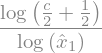

In [19]:
solve_lb(k=1,)[0]

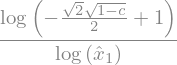

In [20]:
solve_lb(k=2,)[0]

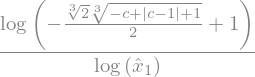

In [21]:
solve_lb(k=3,)[0]

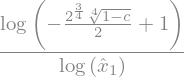

In [22]:
solve_lb(k=4,)[-2]

In [23]:
solve_lb(k=5,)

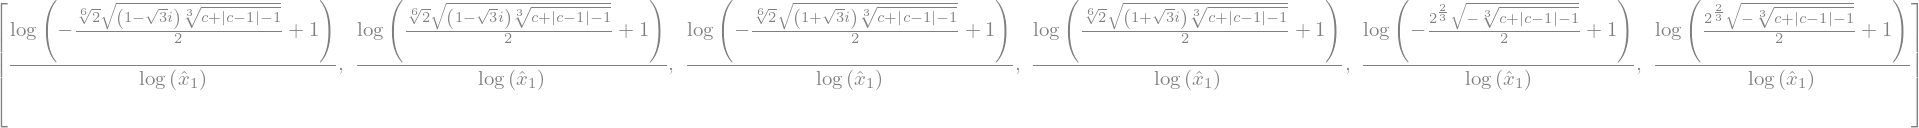

In [24]:
solve_lb(k=6,)

In [25]:
solve_lb(k=7,)

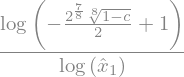

In [26]:
solve_lb(k=8,)[6]

Solution appears to be of the form

$\begin{align*}
n_\mathrm{lb}
&=\frac{
    \log \Big( - \frac{2^\frac{k-1}{k} (1-c)^{1/k}}{2} + 1 \Big)
}{\log( \hat{x}_1 )}\\
&=\frac{
    \log \Big( - 2^\frac{-1}{k} (1-c)^{1/k} + 1 \Big)
}{\log( \hat{x}_1 )}\\
&=\frac{
    \log \Big( - \frac{1-c}{2}^{1/k} + 1 \Big)
}{\log( \hat{x}_1 )}\\
&=\frac{
    \log \Big( 1 - \frac{1-c}{2}^{1/k} \Big)
}{\log( \hat{x}_1 )}.
\end{align*}$

However, the consistency of Sympy's symbolic integration is spottier than for calculating the upper bound.  

# Validating Lower Bound Extrapolation

In [27]:
def expected_lb(*, k: int, c: float, x1: float) -> float:
    return math.log(
        1 - ((1-c)/2)**(1/k)
        ) / math.log(
        x1
    )


In [28]:
def validate_lb(*, k: int, c: float, x1: float,) -> float:

    n = expected_lb(k=k, c=c, x1=x1)
    
    # not used: sympy too slow
    # x = sympy.Symbol('x', nonnegative=True, real=True,)
    # probability_density = k * n * x ** (n - 1) * (1 - x**n)**(k-1)
    # integrated = sympy.Integral(
    #     probability_density,
    #     (x, x1, 1.0),
    # ).evalf()
    
    integrated, err = integrate.quad(
        lambda x: k * n * x ** (n - 1) * (1 - x**n)**(k-1),
        x1,
        1,
    )
    assert err < 1e-6, err
    
    return math.isclose(integrated, (1-c)/2, abs_tol=err,)


In [29]:
for k in range(1,1001,50):
    for c in np.linspace(0.01, 0.99, 10):
        for x1 in np.linspace(0.01, 0.99, 10):
            assert validate_lb(k=k, c=c, x1=x1), (k, c, x1)


# Simulated Experiments

In [35]:
def sample_observations(
    true_popsize: int,
    num_observations: int,
) -> typing.List[float]:
    """Simulate sampling the largest gene from within a population of `true_popsize` `num_observations` times."""
    return [
        max(random.random() for __ in range(true_popsize))
        for __ in range(num_observations)
    ]

def estimate_popsize_bounds(
    observations: typing.List[float],
) -> typing.Tuple[float, float]:

    lb = math.log( 
        - ( (1+0.95)/2 ) ** (1/len(observations)) + 1
    ) / math.log(
            min(observations)
    )
    ub = math.log( 
        - ( (1-0.95)/2 ) ** (1/len(observations)) + 1,
    ) / math.log(
            min(observations),
    )

    return (ub, lb,)

def sample_popsize_bounds(
    true_popsize: int, 
    num_observations: int,
) -> typing.Tuple[float, float]:
    """Generate sampled largest genes from `true_popsize` population
    and then use maximum likelihood estimator to estimate `true_popsize`."""
    return estimate_popsize_bounds(sample_observations(true_popsize, num_observations))


In [43]:
# simulate gene drive within populations and then subsequent estimates of population size from magnitude of fixed genes
records = []
for num_observations in 1, 2, 4, 8, 10, 20, 100:
    for true_popsize in 10, 1000:
        sampled_ci_bounds = [
            sample_popsize_bounds(
                true_popsize,
                num_observations,
            )
            for __ in range(200)
        ]

        num_confidence_intervals_containing_true_popsize = sum(
            bool(lb_ <= true_popsize <= ub_)
            for lb_, ub_ in sampled_ci_bounds
        )

        records.append({
            'Num Observations' : num_observations,
            'True Population Size' : true_popsize,
            'Fraction Estimates within 95% Confidence Interval'
                : num_confidence_intervals_containing_true_popsize / len(sampled_ci_bounds),
            'Mean Normalized Confidence Interval Width' : np.mean([ub_ - lb_ for lb_, ub_ in sampled_ci_bounds]) / true_popsize,
            'Mean Normalized Confidence Interval Lower Bound' : np.mean([lb_ for lb_, ub_ in sampled_ci_bounds]) / true_popsize,            'Mean Lower CI Bound' : np.mean([lb_ for lb_, __ in sampled_ci_bounds]), 
            'Mean Normalized Confidence Interval Upper Bound' : np.mean([ub_ for lb_, ub_ in sampled_ci_bounds]) / true_popsize,            'Mean Lower CI Bound' : np.mean([lb_ for lb_, __ in sampled_ci_bounds]), 
            'Mean Upper CI Bound' : np.mean([ub_ for __, ub_ in sampled_ci_bounds]), 
            'Median Lower CI Bound' : np.median([lb_ for lb_, __ in sampled_ci_bounds]), 
            'Median Upper CI Bound' : np.median([ub_ for __, ub_ in sampled_ci_bounds]), 
            'p As Many Estimates Outside Credible Interval'
                : stats.binom.cdf(num_confidence_intervals_containing_true_popsize, len(sampled_ci_bounds), 0.95),
        })

res_df = pd.DataFrame.from_records(records)
res_df.round(5)


,Num Observations,True Population Size,Fraction Estimates within 95% Confidence Interval,Mean Normalized Confidence Interval Width,Mean Normalized Confidence Interval Lower Bound,Mean Lower CI Bound,Mean Normalized Confidence Interval Upper Bound,Mean Upper CI Bound,Median Lower CI Bound,Median Upper CI Bound,p As Many Estimates Outside Credible Interval
0,1,10,0.965,12.06640,0.08339,0.83387,12.14979,121.49788,0.36334,52.93939,0.87626
1,1,1000,0.955,17.37264,0.12006,120.05728,17.49270,17492.70103,35.32566,5147.05358,0.67298
2,2,10,0.905,6.87588,0.28152,2.81523,7.15740,71.57401,1.35380,34.41875,0.00582
3,2,1000,0.930,8.37179,0.34277,342.77068,8.71456,8714.56030,129.10115,3282.25214,0.12989
4,4,10,0.950,3.12202,0.34714,3.47136,3.46916,34.69158,2.73947,27.37729,0.54529
5,4,1000,0.955,3.03792,0.33778,337.78493,3.37570,3375.70463,265.18853,2650.20158,0.67298
6,8,10,0.915,2.27793,0.47642,4.76417,2.75435,27.54346,4.01310,23.20125,0.02380
7,8,1000,0.930,2.10728,0.44073,440.72728,2.54801,2548.01112,392.93235,2271.69056,0.12989
8,10,10,0.980,1.89211,0.46319,4.63193,2.35530,23.55305,4.28749,21.80161,0.99095
9,10,1000,0.955,1.98420,0.48574,485.73523,2.46993,2469.93073,432.20646,2197.74057,0.67298


# Result

For the least-extreme observation of fixed gene magnitude $\hat{x}_1$ from among $k$ observations, the population size $n$ can be estimated with $c\%$ confidence to fall within the interval

$\begin{align*}
\Big(
\frac{
    \log \Big( 1 - \frac{1-c}{2}^{1/k} \Big)
}{\log( \hat{x}_1 )},
\frac{
    \log \Big( 1 - \frac{1+c}{2}^{1/k} \Big)
}{\log( \hat{x}_1 )}
\Big).
\end{align*}$

Simulated experiments support the validity of this result.

# References

<a
   id="miller2017probability"
   href="https://press.princeton.edu/books/hardcover/9780691149547/the-probability-lifesaver">
Miller, Steven J. The Probability Lifesaver. Princeton University Press, 2017.
</a>
    * supplementary chapter "Order Statistics and the Median Theorem" retrieved from <https://web.williams.edu/Mathematics/sjmiller/public_html/probabilitylifesaver/supplementalchap_mediantheoremandorderstatistics.pdf>
